In [1]:
#install.packages("pdp")

In [2]:
options(repr.plot.width  = 15,
        repr.plot.height = 10)

In [3]:
# Helper packages
library(dplyr)       # for data wrangling
library(ggplot2)     # for awesome plotting

# Modeling packages
library(rpart)       # direct engine for decision tree application
library(caret)       # meta engine for decision tree application

# Model interpretability packages
library(rpart.plot)  # for plotting decision trees
library(vip)         # for feature importance
library(pdp)         # for feature effects


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




# Split a tree

## Regression

In [4]:
data  <- data.frame(x = c(1:10), y = c(3, 2, 2, 3, 5, 5, 6, 8, 9, 8))
data

x,y
<int>,<dbl>
1,3
2,2
3,2
4,3
5,5
6,5
7,6
8,8
9,9


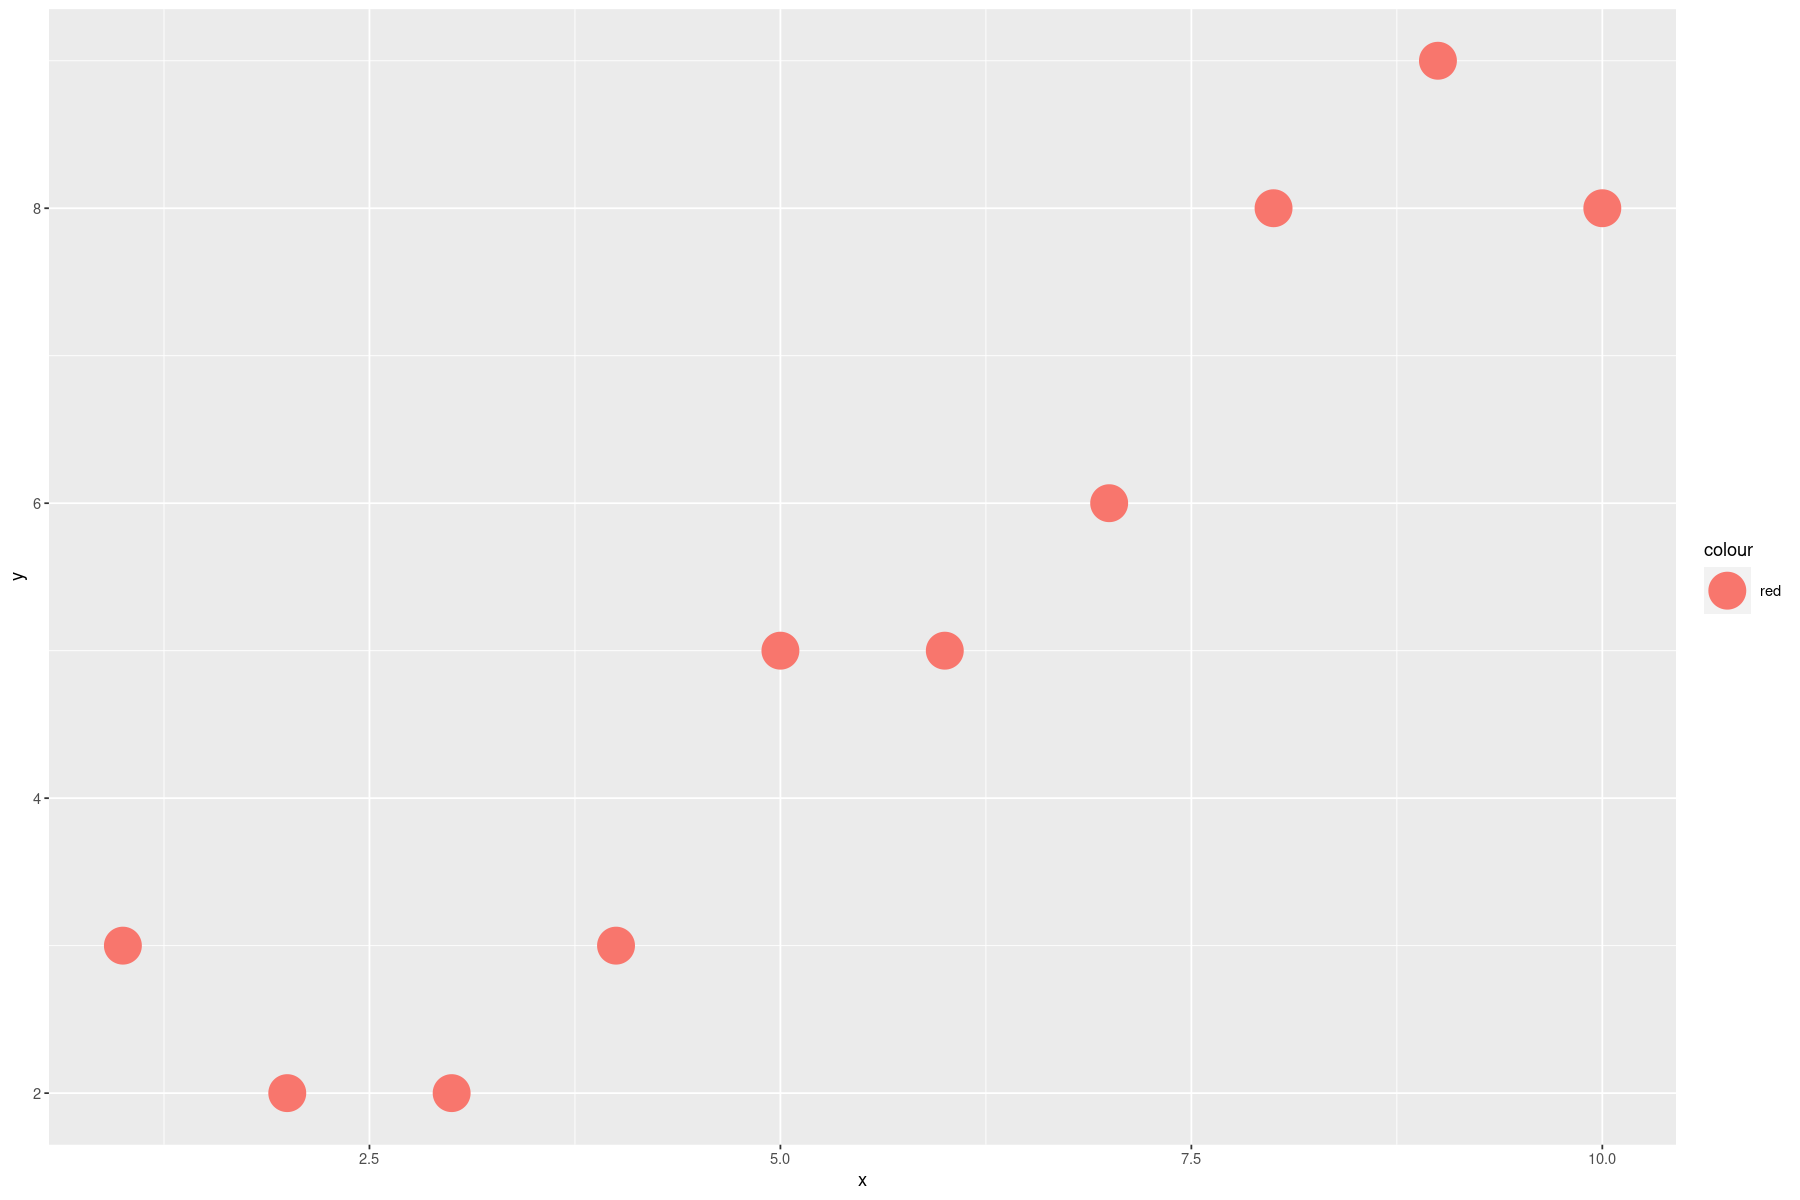

In [5]:
ggplot(data, aes(x=x, y=y, color="red")) + geom_point(size=10)

In [6]:
sse <- function(p1, p2){
  sse1 = sum((p1 - mean(p1))^2)
  sse2 = sum((p2 - mean(p2))^2)
  
  return(sse1 + sse2)
}

In [7]:
split1 = data$x <= 7
p1 = data[split1,]
p2 = data[!split1,]
sse(p1$y, p2$y)

[1] 16.09524

In [37]:
for (k in 1:9) {
    split1 = data$x <= k
    p1 = data[split1,]
    p2 = data[!split1,]
    print(paste(k, sse(p1$y, p2$y)))
}

[1] "1 56"
[1] "2 44"
[1] "3 28.0952380952381"
[1] "4 15.8333333333333"
[1] "5 16.8"
[1] "6 14.0833333333333"
[1] "7 16.0952380952381"
[1] "8 32"
[1] "9 51.5555555555556"


In [38]:
split1 = data$x <= 6
p1 = data[split1,]
p2 = data[!split1,]
sse(p1$y, p2$y)

[1] 14.08333

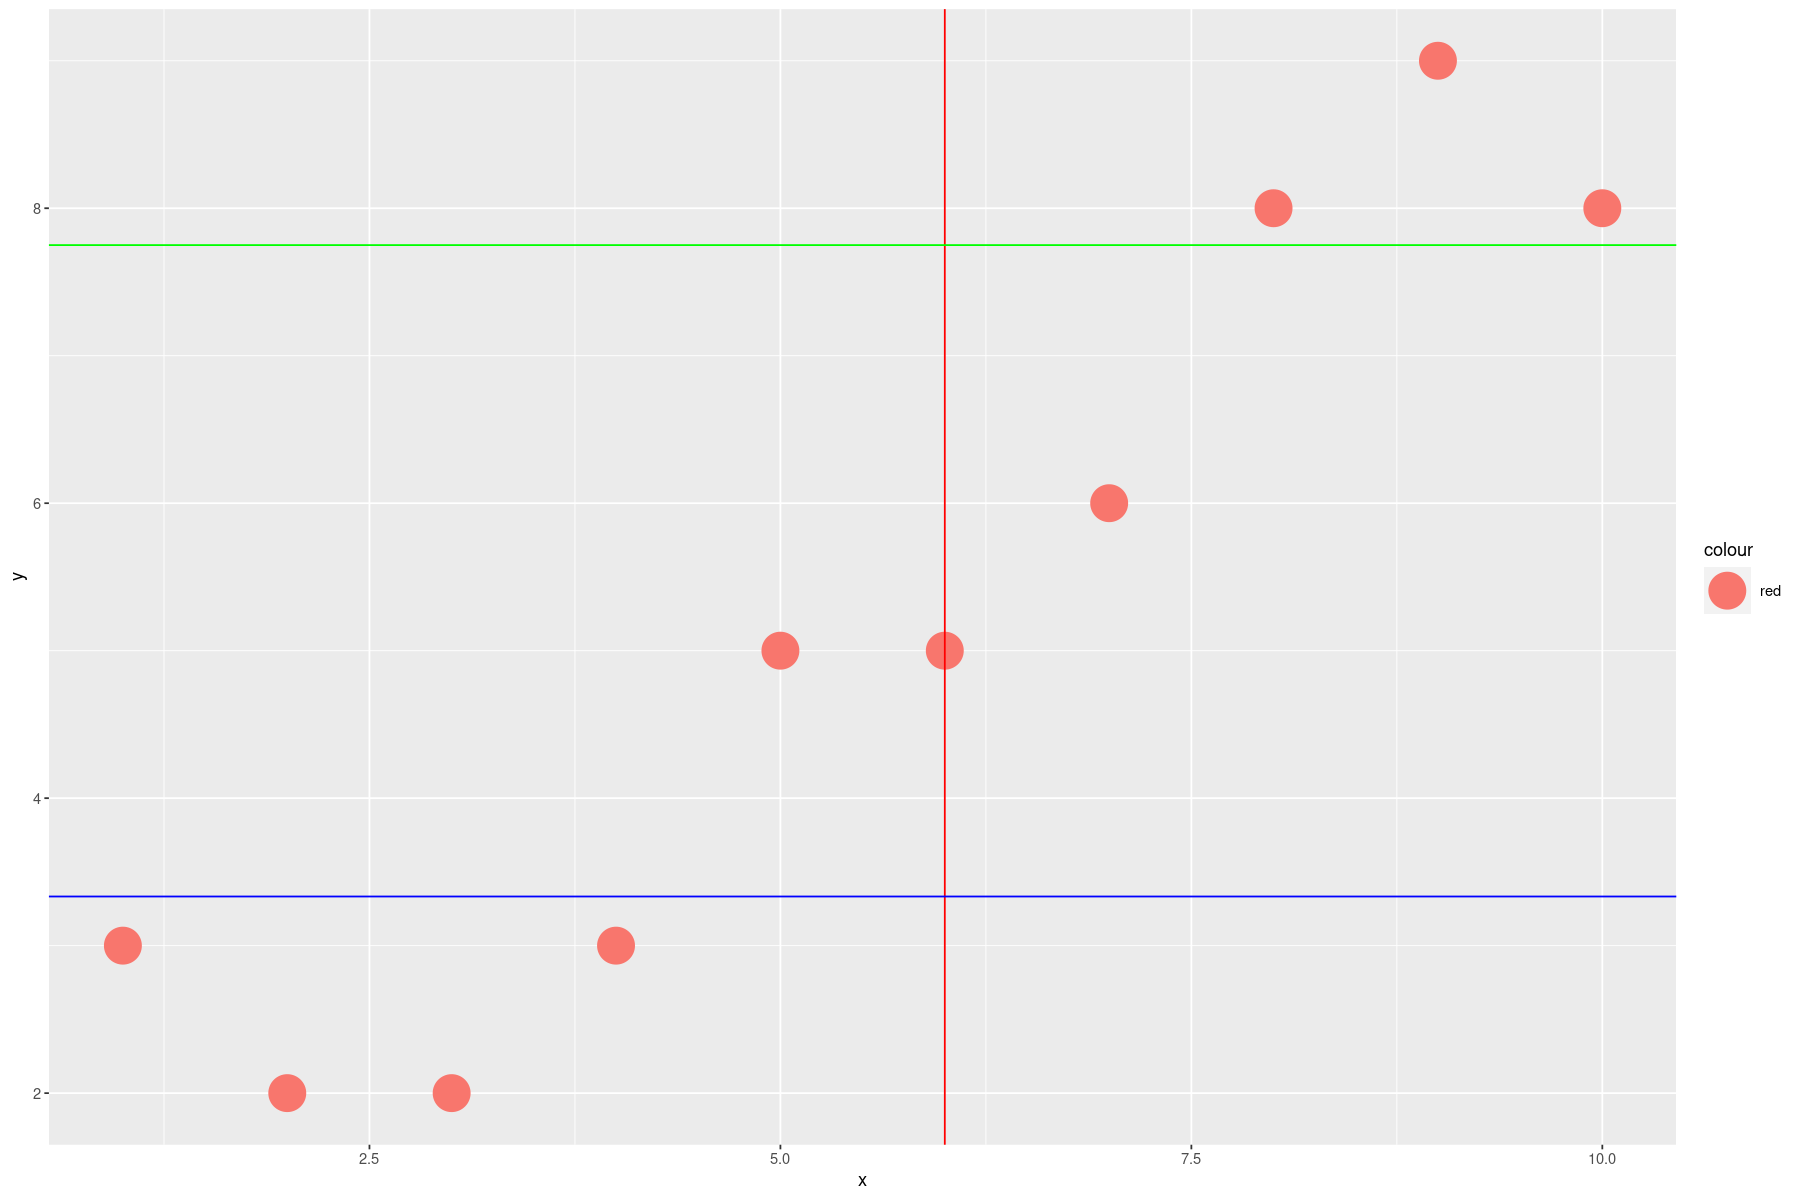

In [10]:
ggplot(data, aes(x=x, y=y, color="red")) +
    geom_point(size=10) + 
    geom_vline(xintercept = 6, color='red') + 
    geom_hline(yintercept = mean(p1$y), color='blue') + 
    geom_hline(yintercept = mean(p2$y), color='green')

In [11]:
for (k in 1:5) {
    split1 = p1$x <= k
    p1_1 = p1[split1,]
    p1_2 = p1[!split1,]
    print(paste(k, sse(p1_1$y, p1_2$y)))
}

[1] "1 9.2"
[1] "2 7.25"
[1] "3 3.33333333333333"
[1] "4 1"
[1] "5 6"


In [12]:
mean(p1$y)

[1] 3.333333

## Classification

<img src="https://hsto.org/webt/o4/nx/p7/o4nxp7itpg_zxowtmffs5xh3bbw.png">

In [13]:
data_class  <- data.frame(x = c(1:10), y = c(1, 1, 2, 2, 2, 2, 1, 1, 2, 2))
data_class

x,y
<int>,<dbl>
1,1
2,1
3,2
4,2
5,2
6,2
7,1
8,1
9,2


In [14]:
entropy <- function(data){
  p1 = mean(data == 1)
  p2 = mean(data == 2)
  result = -(p1 * log2(p1) + p2 * log2(p2))
  return(result)
}

gini <- function(data){
  p1 = mean(data == 1)
  p2 = mean(data == 2)
  result = 1 - (p1^2 + p2^2)
  return(result)
}

information_gain  <- function(root, p1, p2){
    s0 = entropy(root)
    s1 = entropy(p1)
    s2 = entropy(p2)
    n0 = length(root)
    n1 = length(p1)
    n2 = length(p2)
    return (s0 - (n1*s1 + n2*s2)/n0)
}

split 0 - root node

In [15]:
s_0 = entropy(data_class$y)
s_0

[1] 0.9709506

In [16]:
split1 = data_class$x <= 7
p1 = data_class[split1,]
p2 = data_class[!split1,]
information_gain(data_class$y, p1$y, p2$y)

[1] 0.005802149

In [17]:
for (k in 1:9) {
    split1 = data_class$x <= k
    p1 = data_class[split1,]
    p1 = data_class[!split1,]
    print(paste(k, information_gain(data_class$y, p1$y, p2$y)))
}

[1] "1 -0.131004406410719"
[1] "2 0.0464393446710154"
[1] "3 0.09127744624168"
[1] "4 0.144484343805628"
[1] "5 0.209986547010987"
[1] "6 0.295461844238322"
[1] "7 0.419973094021975"
[1] "8 NaN"
[1] "9 NaN"


# Decision Tree - Regression

[Documentacion de rpart](https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf)

Hiperparametros
* minsplit
* minbucket
* maxdepth
* cp 


## Load data

In [18]:
ames <- AmesHousing::make_ames()

In [39]:
dim(ames)

[1] 2930   81

## Split Data

In [19]:
index_2 <- createDataPartition(ames$Sale_Price, p = 0.7, 
                               list = FALSE, )
house_train <- ames[index_2, ]
house_test  <- ames[-index_2, ]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


## Modeling

In [44]:
?rpart

In [50]:
ames_dt1 <- rpart(
  formula = Sale_Price ~ .,
  data    = house_train,
  method  = "anova",
  control = rpart.control(maxdepth=1)
)

In [51]:
ames_dt1

n= 2053 

node), split, n, deviance, yval
      * denotes terminal node

1) root 2053 1.295118e+13 180503.2  
  2) Overall_Qual=Very_Poor,Poor,Fair,Below_Average,Average,Above_Average,Good 1720 4.161269e+12 156699.1 *
  3) Overall_Qual=Very_Good,Excellent,Very_Excellent 333 2.781287e+12 303455.0 *

In [42]:
ames_dt1 <- rpart(
  formula = Sale_Price ~ .,
  data    = house_train,
  method  = "anova",
  minbucket = 5
)

In [43]:
ames_dt1

n= 2053 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 2053 1.295118e+13 180503.20  
   2) Overall_Qual=Very_Poor,Poor,Fair,Below_Average,Average,Above_Average,Good 1720 4.161269e+12 156699.10  
     4) Neighborhood=North_Ames,Old_Town,Edwards,Sawyer,Mitchell,Brookside,Iowa_DOT_and_Rail_Road,South_and_West_of_Iowa_State_University,Meadow_Village,Briardale,Northpark_Villa,Blueste,Landmark 1023 1.376311e+12 132175.50  
       8) First_Flr_SF< 1095.5 674 5.466373e+11 120420.50  
        16) Overall_Qual=Very_Poor,Poor,Fair,Below_Average 155 1.067143e+11  92600.02 *
        17) Overall_Qual=Average,Above_Average,Good 519 2.841280e+11 128729.10 *
       9) First_Flr_SF>=1095.5 349 5.566761e+11 154877.20 *
     5) Neighborhood=College_Creek,Somerset,Northridge_Heights,Gilbert,Northwest_Ames,Sawyer_West,Crawford,Timberland,Northridge,Stone_Brook,Clear_Creek,Bloomington_Heights,Veenker,Green_Hills 697 1.266726e+12 192692.80  
      10) Gr_Liv_Area< 1482.5 294 2.57964

node) | criterio | n_samples | sse | mean(y)

In [21]:
ames_dt1

n= 2053 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 2053 1.295118e+13 180503.20  
   2) Overall_Qual=Very_Poor,Poor,Fair,Below_Average,Average,Above_Average,Good 1720 4.161269e+12 156699.10  
     4) Neighborhood=North_Ames,Old_Town,Edwards,Sawyer,Mitchell,Brookside,Iowa_DOT_and_Rail_Road,South_and_West_of_Iowa_State_University,Meadow_Village,Briardale,Northpark_Villa,Blueste,Landmark 1023 1.376311e+12 132175.50  
       8) First_Flr_SF< 1095.5 674 5.466373e+11 120420.50  
        16) Overall_Qual=Very_Poor,Poor,Fair,Below_Average 155 1.067143e+11  92600.02 *
        17) Overall_Qual=Average,Above_Average,Good 519 2.841280e+11 128729.10 *
       9) First_Flr_SF>=1095.5 349 5.566761e+11 154877.20 *
     5) Neighborhood=College_Creek,Somerset,Northridge_Heights,Gilbert,Northwest_Ames,Sawyer_West,Crawford,Timberland,Northridge,Stone_Brook,Clear_Creek,Bloomington_Heights,Veenker,Green_Hills 697 1.266726e+12 192692.80  
      10) Gr_Liv_Area< 1482.5 294 2.57964

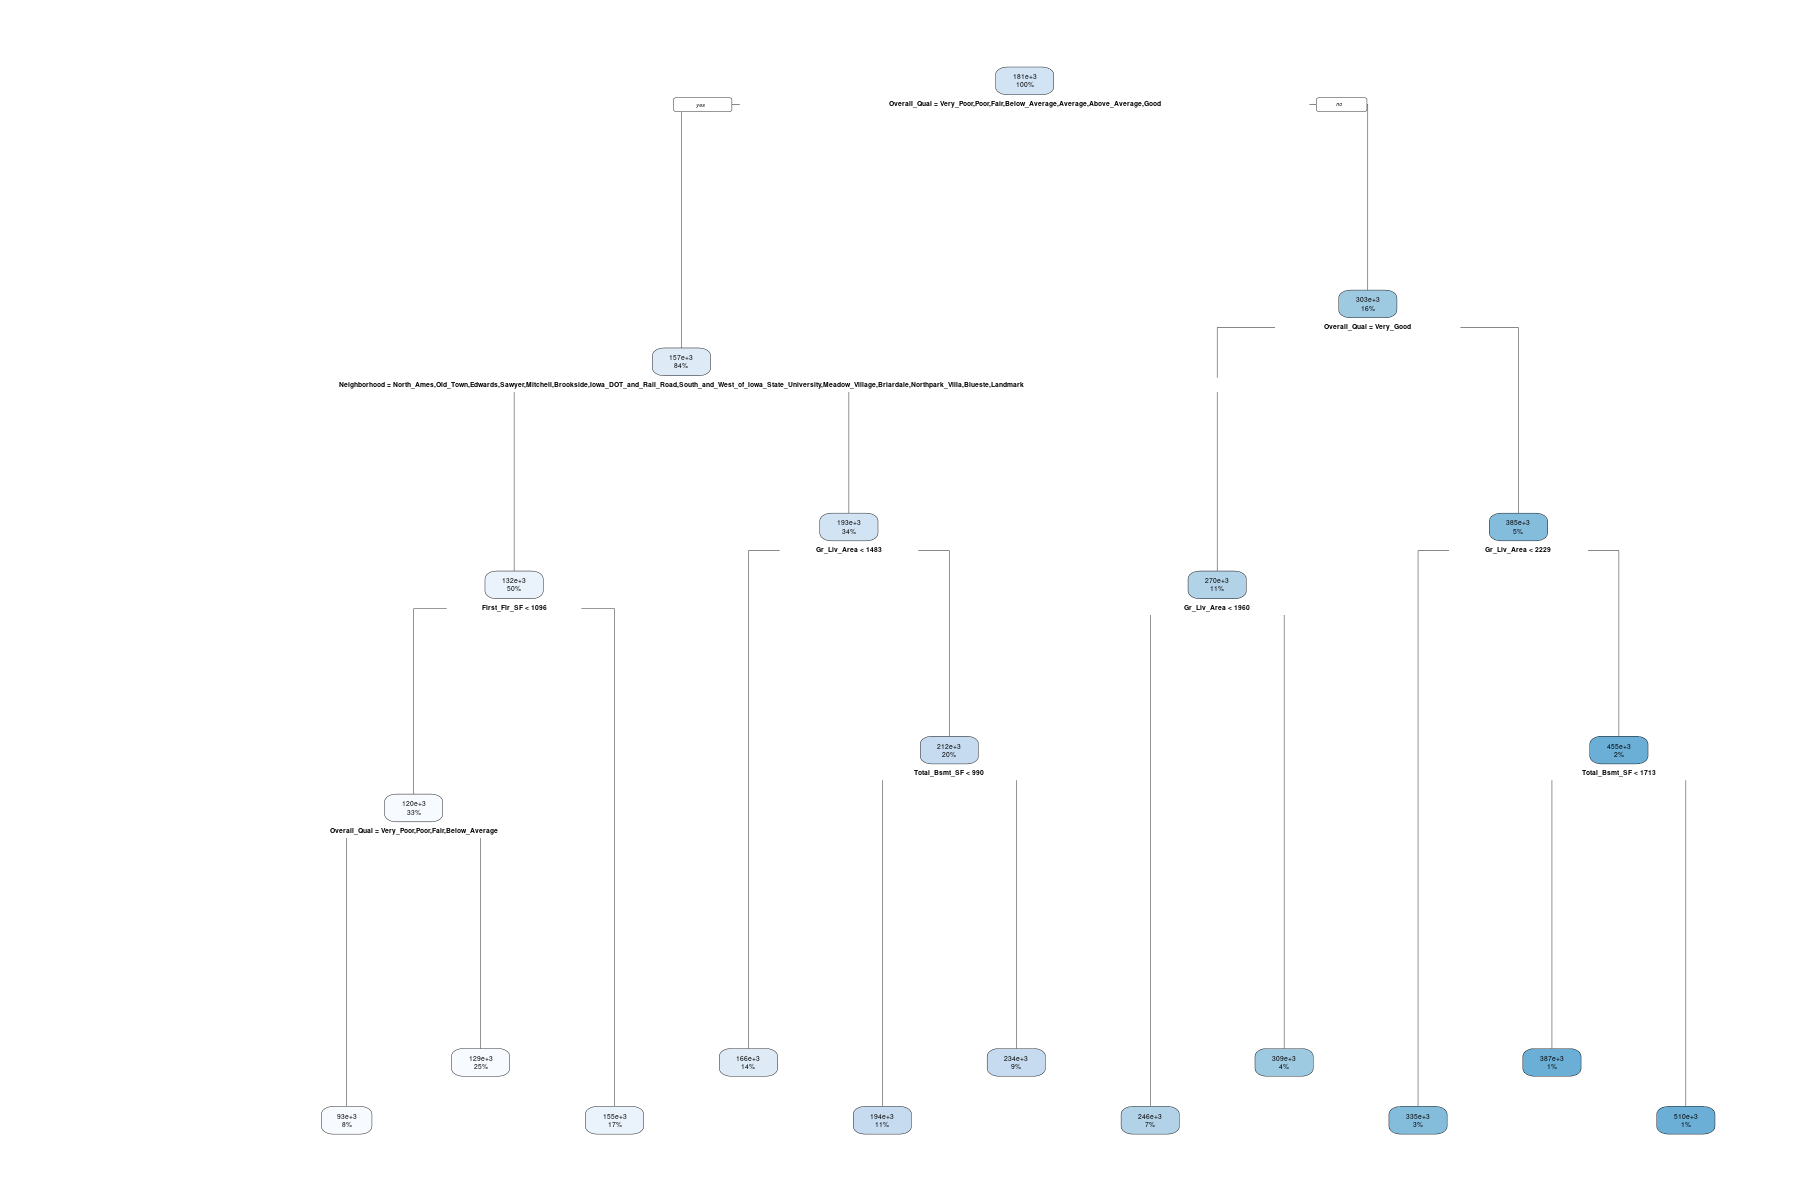

In [22]:
rpart.plot(ames_dt1)

### Different cp values

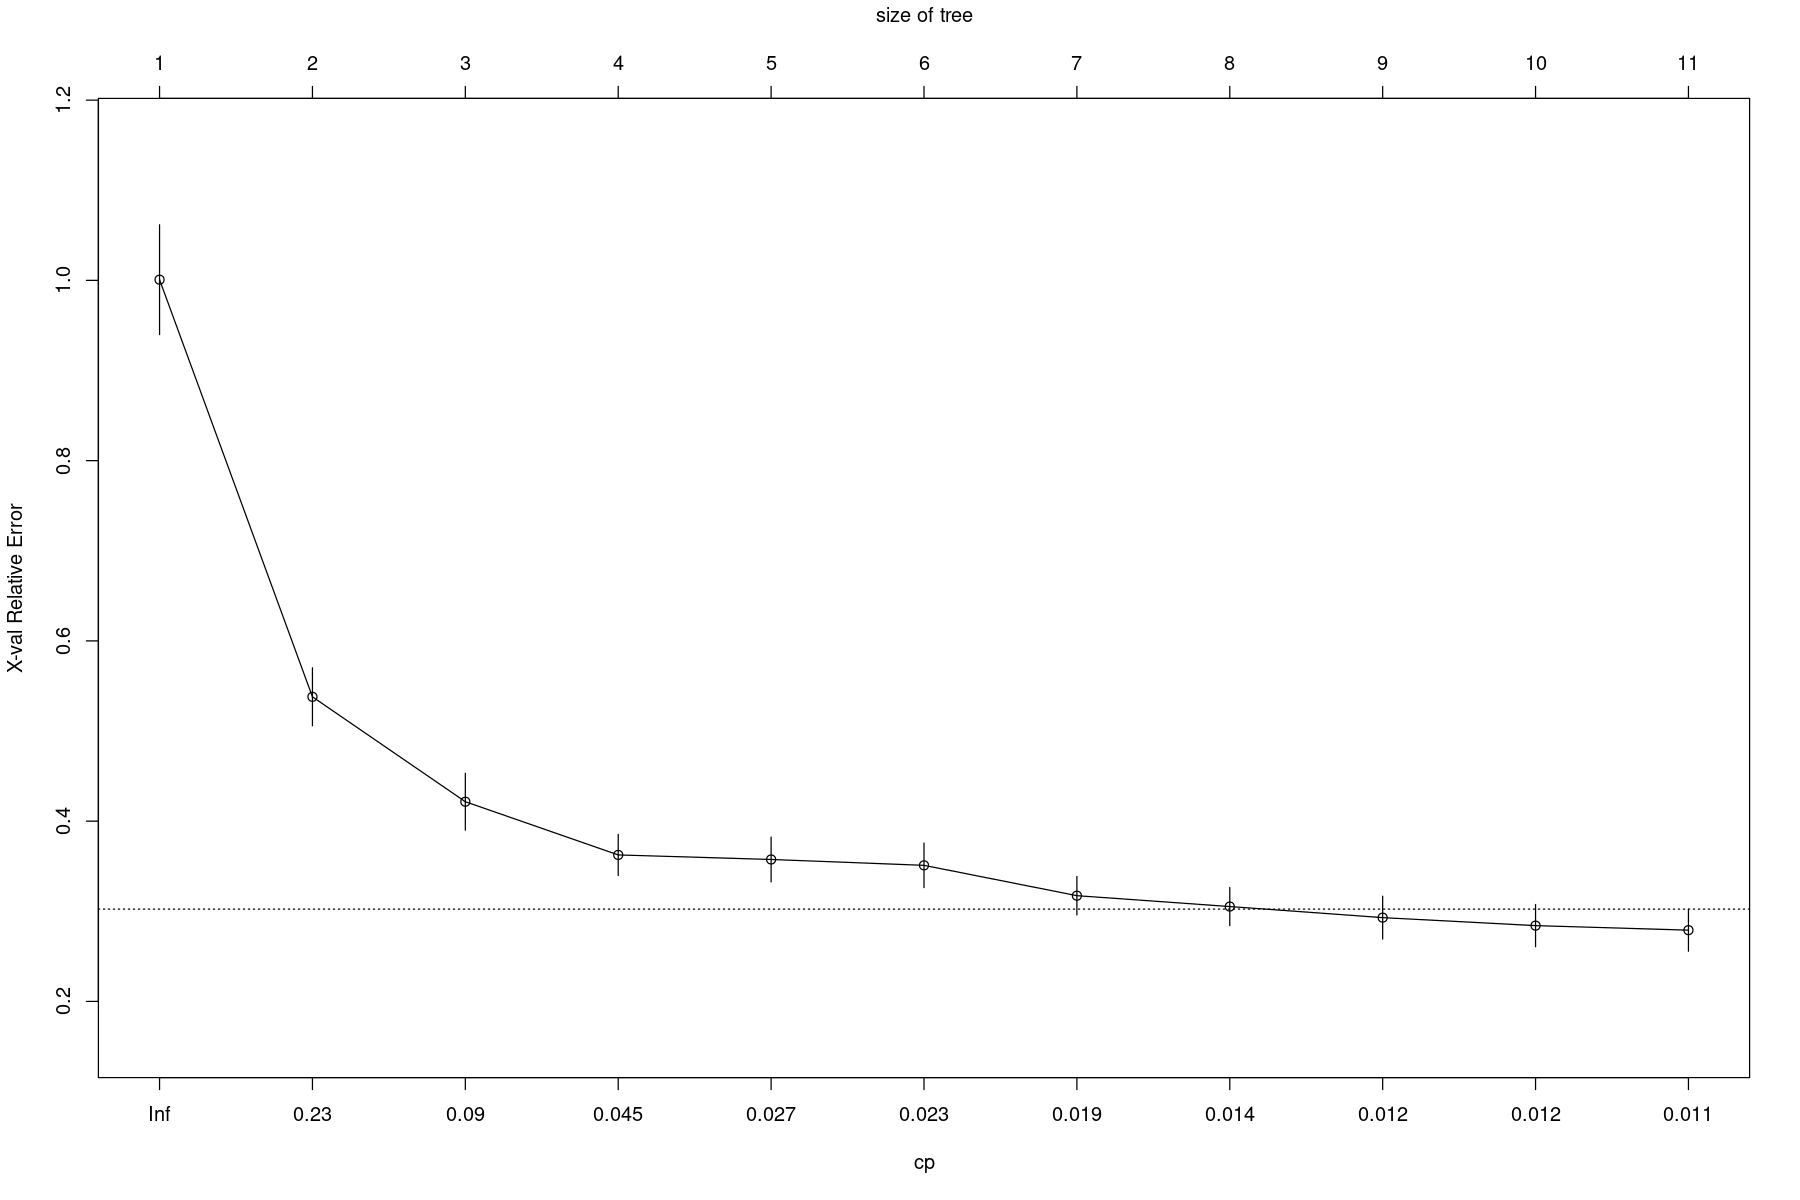

In [23]:
plotcp(ames_dt1)

Que pasa si queremos dejar que el arbol cresca sin restricciones?

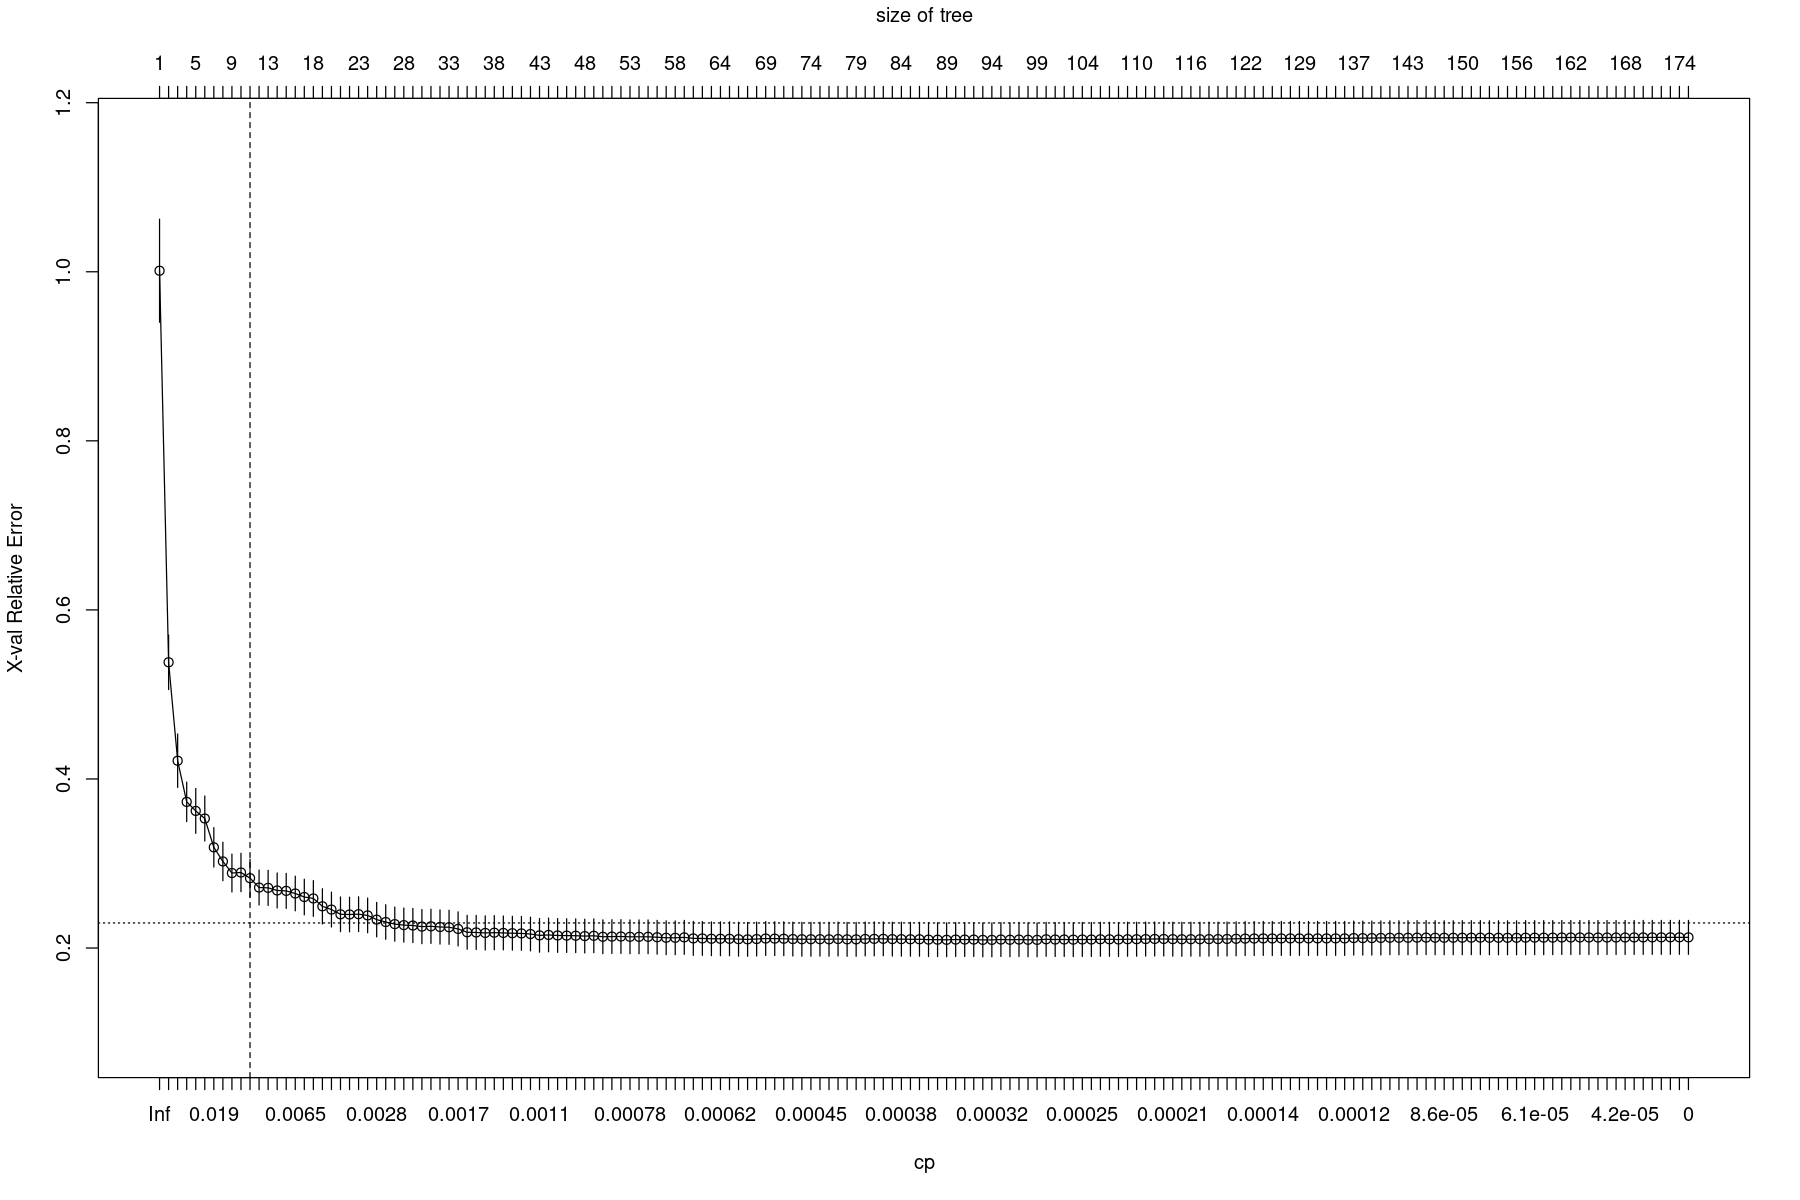

In [24]:
ames_dt2 <- rpart(
    formula = Sale_Price ~ .,
    data    = house_train,
    method  = "anova", 
    control = list(cp = 0, xval = 10)
)

plotcp(ames_dt2)
abline(v = 11, lty = "dashed")

Rpart no no tiene integrado otras metricas como RMSE para ellos vamos a usar Caret

In [25]:
# caret cross validation results
ames_dt3 <- train(
  Sale_Price ~ .,
  data = house_train,
  method = "rpart",
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 20  ## number of diferent cp values
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [26]:
ames_dt3

CART 

2053 samples
  80 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1849, 1847, 1849, 1848, 1846, 1846, ... 
Resampling results across tuning parameters:

  cp           RMSE      Rsquared   MAE     
  0.004043480  38833.92  0.7643978  27149.72
  0.004446591  38879.94  0.7638626  27201.48
  0.004724667  39336.57  0.7576192  27486.49
  0.004927840  39370.34  0.7570943  27500.30
  0.005569014  39862.82  0.7494161  28141.54
  0.005583837  39908.35  0.7489113  28185.20
  0.006012470  40050.28  0.7470208  28361.31
  0.006640297  40885.11  0.7360010  28956.93
  0.006736629  40885.11  0.7360010  28956.93
  0.010619620  41412.12  0.7274526  29995.82
  0.010719033  41412.12  0.7274526  29995.82
  0.019205526  43815.40  0.6936467  31879.35
  0.023891780  45275.51  0.6723196  32884.68
  0.029499821  47099.77  0.6486479  33565.77
  0.031422424  49442.60  0.6111090  35368.81
  0.033335231  50245.75  0.5987303  35825.12
  0.046333996  52091.86  0.565

A menor cp mayor es al profundidad del arbol y menor es el error, pero tambien aumente la probabilidad de hacer overfitting

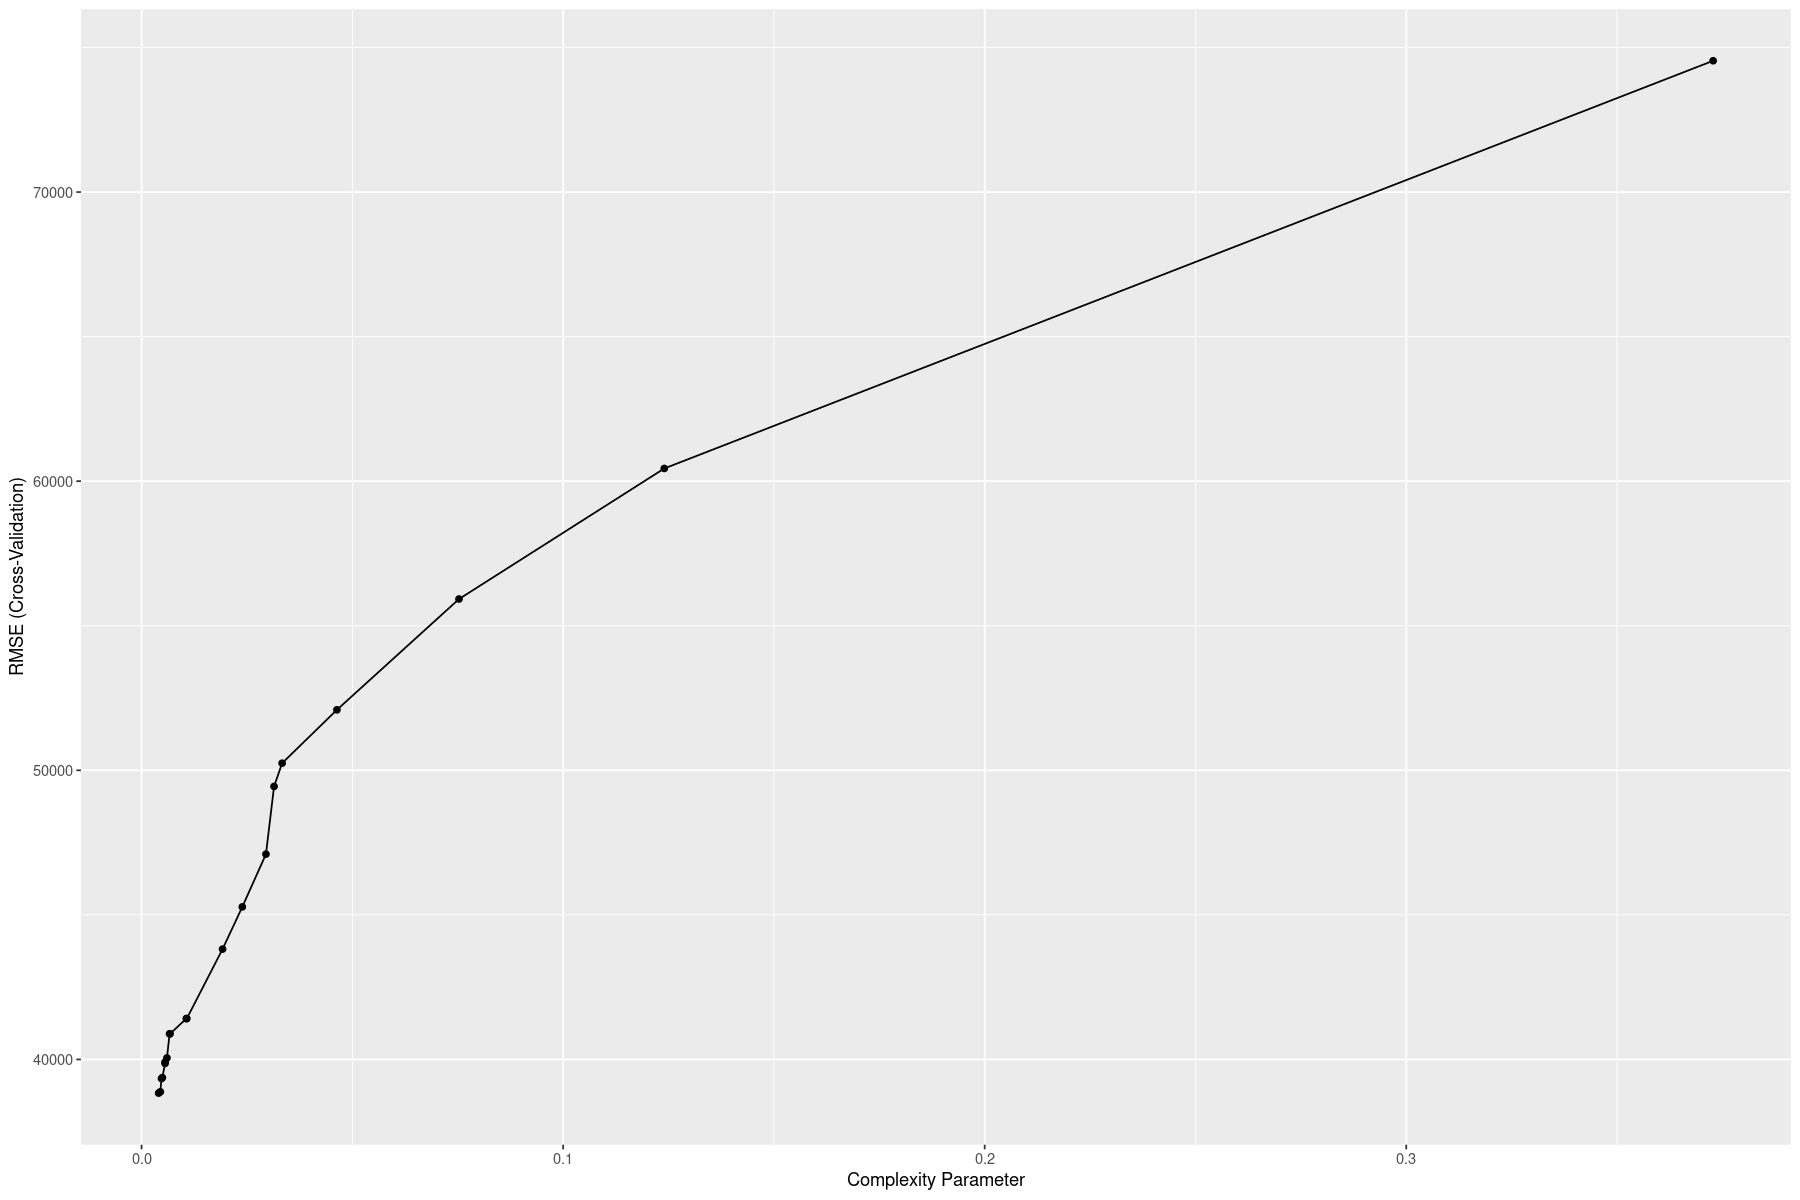

In [27]:
ggplot(ames_dt3)

## Feature importance
- La forma en la que se ponderan las variables se realiza sumando la reduccion en el error de cada split realizado usando una de las variables, dado que una misma variables se podria usar mas de una vez para hacer un split.
- Los abroles automaticamente hacen feaute selection para las variables poco informativas

Warning message in vip.default(ames_dt3, num_features = 40, bar = FALSE):
“The `bar` argument has been deprecated in favor of the new `geom` argument. It will be removed in version 0.3.0.”


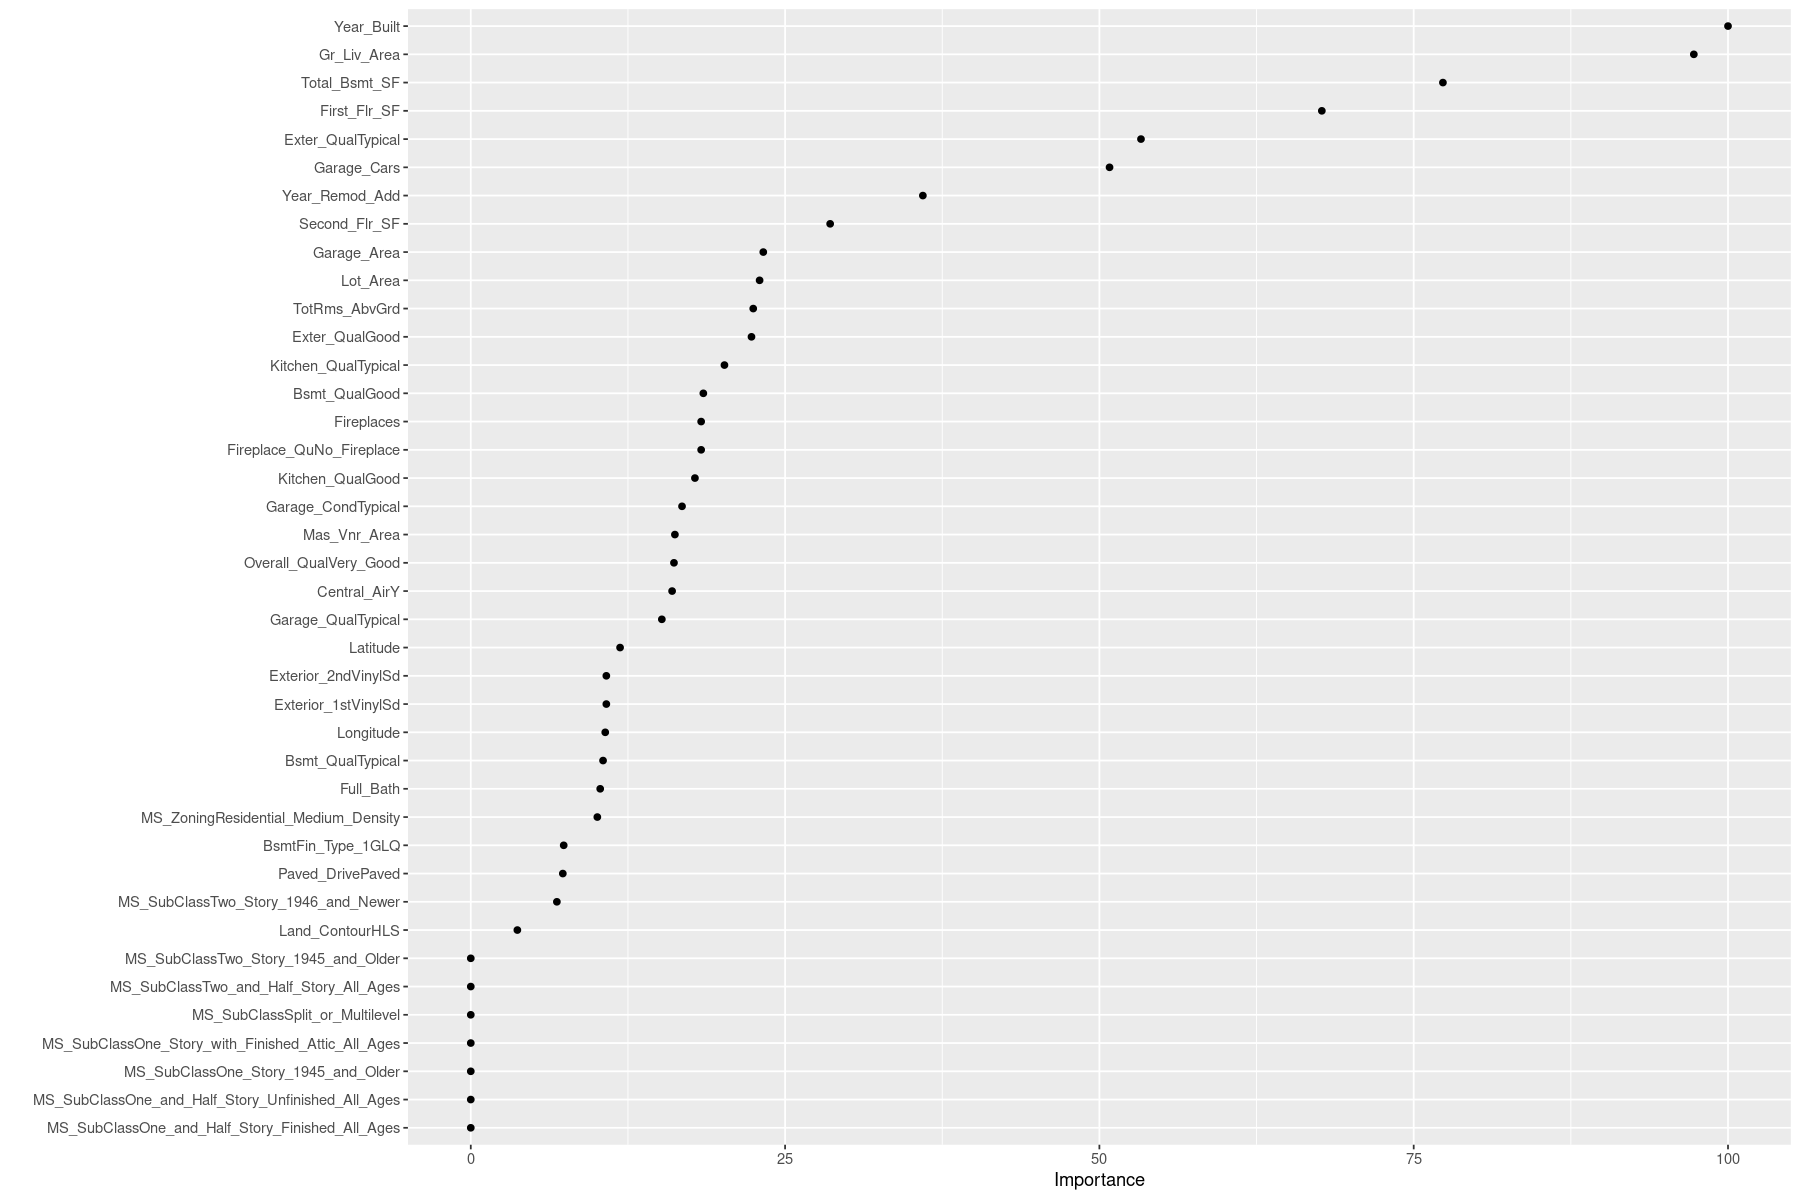

In [28]:
vip(ames_dt3, num_features = 40, bar = FALSE)

# Decision Tree - Classification

class weight
* parms = list(prior = c(p1, 1 - p1)
* parms = list(split = 'information'), 

## Load Data

In [29]:
data("attrition", package = "modeldata")
# Job attrition data
attrition <- attrition %>% 
  mutate_if(is.ordered, .funs = factor, ordered = FALSE)

## Split Data

In [30]:
index_caret <- createDataPartition(attrition$Attrition, p = 0.7, list = FALSE)
attrition_train <- attrition[index_caret, ]
attrition_test  <- attrition[-index_caret, ]

## Modeling

In [31]:
?rpart

In [32]:
attrition_tree <- rpart(
  formula = Attrition ~ .,
  data    = attrition_train,
  method  = "class"
)

In [33]:
attrition_tree

n= 1030 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 1030 166 No (0.8388350 0.1611650)  
    2) OverTime=No 743  76 No (0.8977120 0.1022880) *
    3) OverTime=Yes 287  90 No (0.6864111 0.3135889)  
      6) MonthlyIncome>=3751.5 181  33 No (0.8176796 0.1823204)  
       12) JobRole=Healthcare_Representative,Laboratory_Technician,Manager,Manufacturing_Director,Research_Director,Research_Scientist,Sales_Representative 123  14 No (0.8861789 0.1138211) *
       13) JobRole=Human_Resources,Sales_Executive 58  19 No (0.6724138 0.3275862)  
         26) DistanceFromHome< 11.5 41   7 No (0.8292683 0.1707317) *
         27) DistanceFromHome>=11.5 17   5 Yes (0.2941176 0.7058824) *
      7) MonthlyIncome< 3751.5 106  49 Yes (0.4622642 0.5377358)  
       14) StockOptionLevel>=0.5 53  20 No (0.6226415 0.3773585)  
         28) DailyRate>=888 27   5 No (0.8148148 0.1851852) *
         29) DailyRate< 888 26  11 Yes (0.4230769 0.5769231)  
           58) MonthlyInc

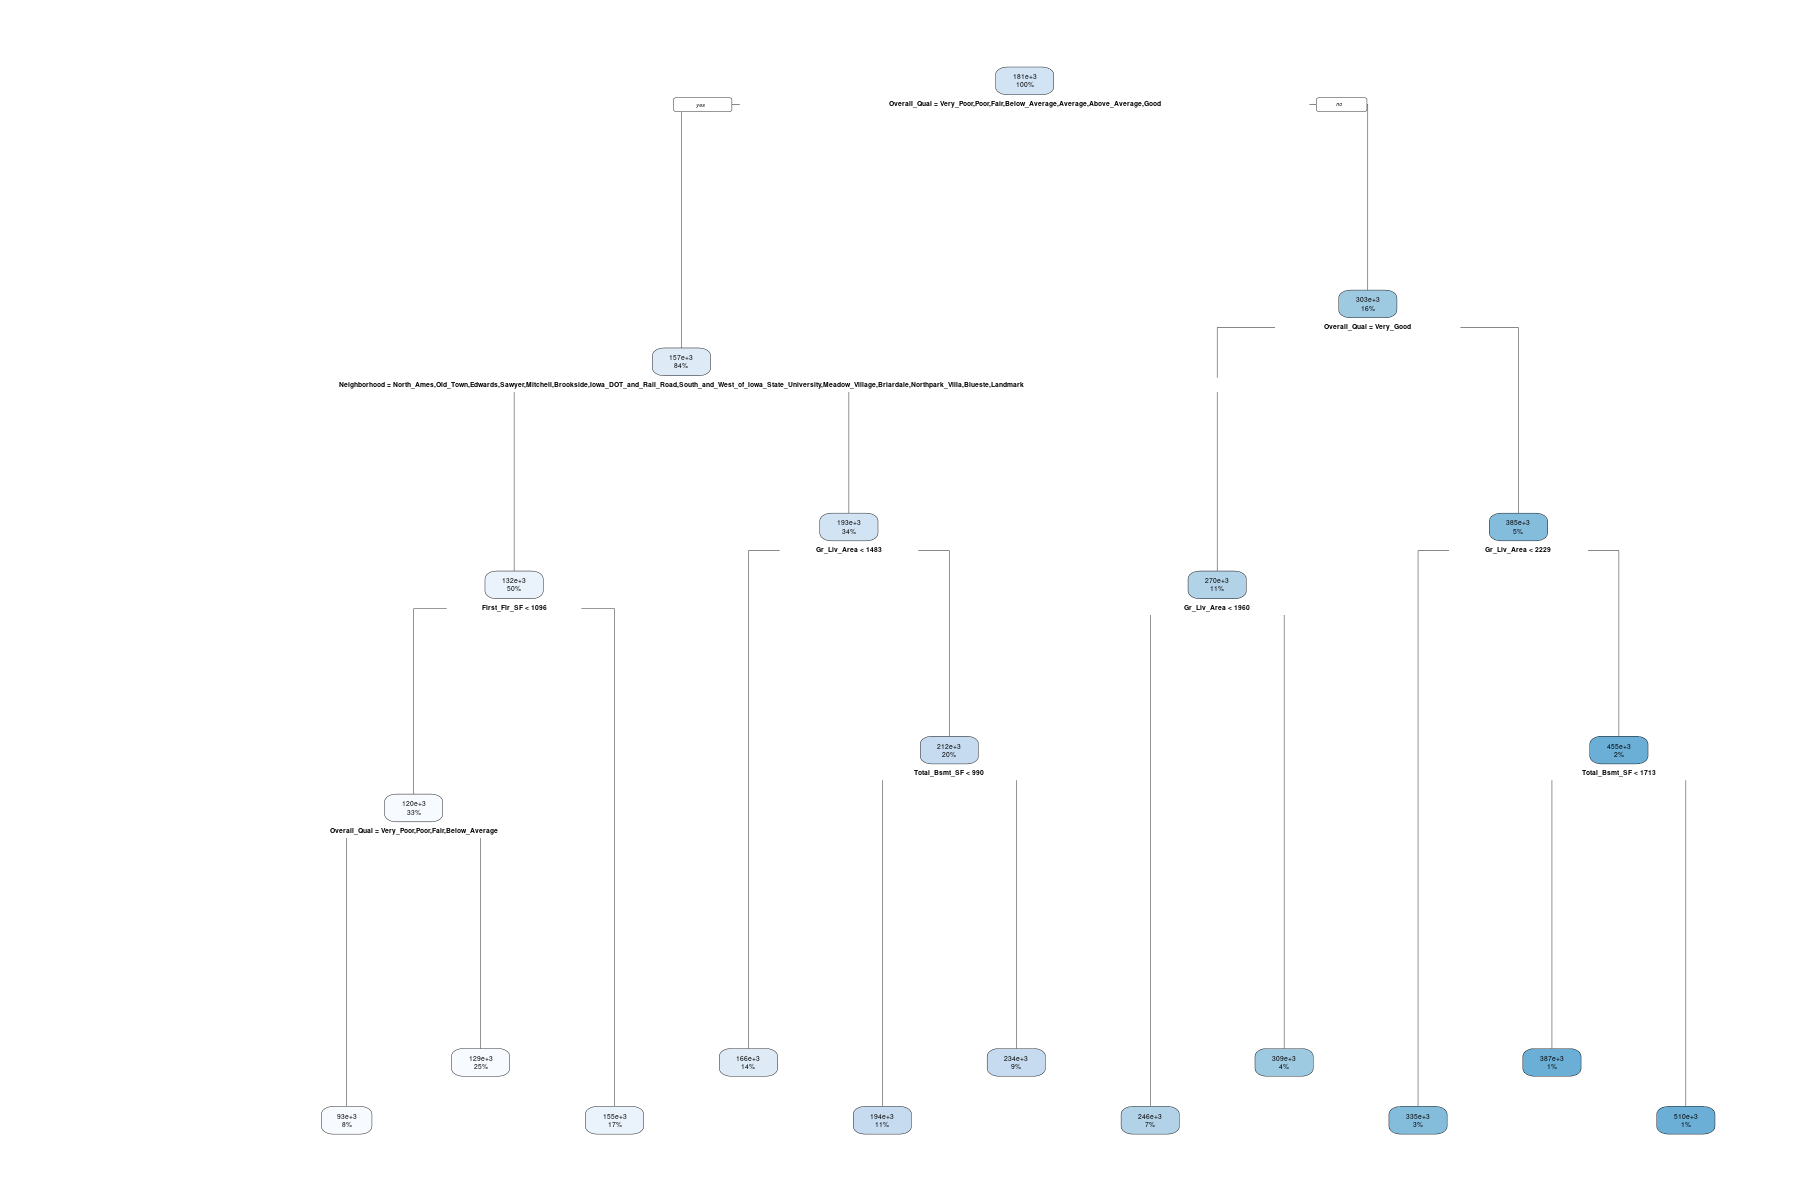

In [34]:
rpart.plot(ames_dt1)

In [35]:
pred_train_class <- predict(attrition_tree, attrition_train, type = "class")
confusionMatrix(
  data = relevel(pred_train_class, ref = "Yes"), 
  reference = relevel(attrition_train$Attrition, ref = "Yes"),
  mode='prec_recall'
)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes  55   9
       No  111 855
                                          
               Accuracy : 0.8835          
                 95% CI : (0.8623, 0.9025)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 3.051e-05       
                                          
                  Kappa : 0.4269          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.85938         
                 Recall : 0.33133         
                     F1 : 0.47826         
             Prevalence : 0.16117         
         Detection Rate : 0.05340         
   Detection Prevalence : 0.06214         
      Balanced Accuracy : 0.66045         
                                          
       'Positive' Class : Yes             
                                          

In [54]:
attrition_tree <- rpart(
  formula = Attrition ~ .,
  data    = attrition_train,
  method  = "class",
    control = rpart.control(maxdepth=4)
)
pred_train_class <- predict(attrition_tree, attrition_train, type = "class")
confusionMatrix(
  data = relevel(pred_train_class, ref = "Yes"), 
  reference = relevel(attrition_train$Attrition, ref = "Yes"),
  mode='prec_recall'
)

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes  64  32
       No  102 832
                                          
               Accuracy : 0.8699          
                 95% CI : (0.8478, 0.8899)
    No Information Rate : 0.8388          
    P-Value [Acc > NIR] : 0.003127        
                                          
                  Kappa : 0.4201          
                                          
 Mcnemar's Test P-Value : 2.512e-09       
                                          
              Precision : 0.66667         
                 Recall : 0.38554         
                     F1 : 0.48855         
             Prevalence : 0.16117         
         Detection Rate : 0.06214         
   Detection Prevalence : 0.09320         
      Balanced Accuracy : 0.67425         
                                          
       'Positive' Class : Yes             
                                          